In [13]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
import skimage.morphology as morph
import skimage.morphology.greyreconstruct as rec
import astropy.io.fits as fits

In [4]:
dc  = io.imread('../../../../../TestData/2D/tiff/spots/dc.tif').astype('float')
img = io.imread('../../../../../TestData/2D/tiff/spots/balls.tif').astype('float')-dc
ob  = io.imread('../../../../../TestData/2D/tiff/spots/ob.tif').astype('float')-dc

img[img<1]=1
ob[ob<1]=1

timg=img/ob
img=-np.log(timg)

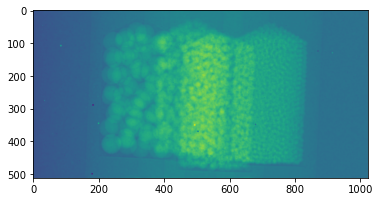

In [5]:
plt.imshow(img)

In [6]:
def fill_hole(img) :
    tmax=img.max()
    fm = img.copy()
    fm[1:-2,1:-2] = tmax
    
    res=rec.reconstruction(fm,img,method='erosion')
    
    return res

In [14]:
def fill_spots(img,size=5) :
    med = flt.median(img,selem=np.ones([size,1]))
    med = flt.median(med,selem=np.ones([1,size]))
    fm = img.copy()
    fm[1:-2,1:-2] = med[1:-2,1:-2]
    fm = np.maximum(fm,img)
    
    res=rec.reconstruction(fm,img,method='erosion')
    
    return res

def fill_spots2(img,size=5) :
    med = morph.dilation(img,selem=np.ones([size,size]))
    
    fm = img.copy()
    fm[1:-2,1:-2] = med[1:-2,1:-2]
    fm = np.maximum(fm,img)
    
    res=rec.reconstruction(fm,img,method='erosion')
    
    return res

In [15]:
fp=-fill_spots2(-timg)
fh=fill_spots2(timg)

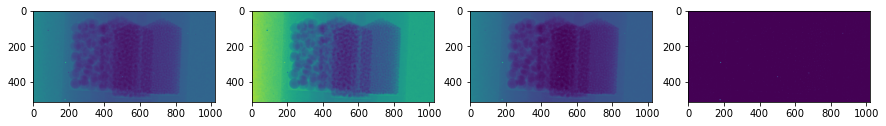

In [16]:
fig,ax =plt.subplots(1,4,figsize=(15,5))
ax[0].imshow(timg)
ax[1].imshow(fp)
ax[2].imshow(fh)
ax[3].imshow(timg-fp)

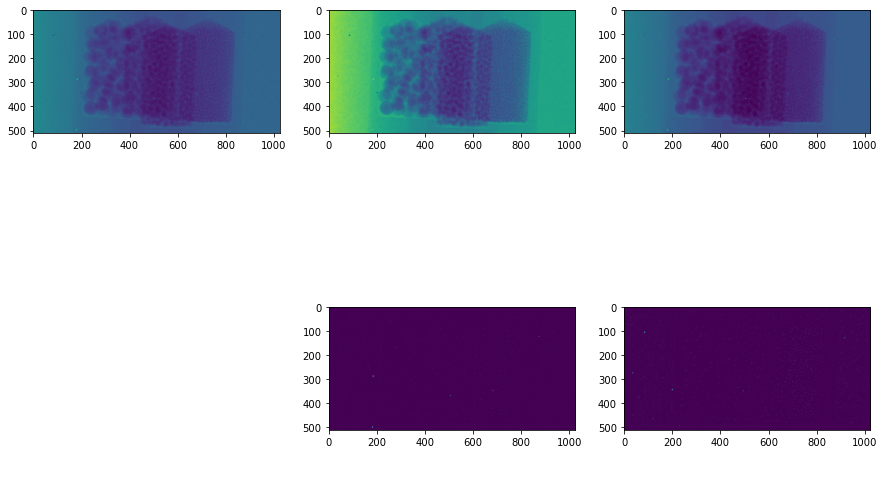

In [18]:
fig,ax =plt.subplots(2,3,figsize=(15,10)); ax=ax.ravel()

dh=np.abs(timg-fh)
dp=np.abs(timg-fp)
ax[0].imshow(timg)
ax[1].imshow(fp)
ax[2].imshow(fh)
ax[3].axis('off')
ax[4].imshow(dp)
ax[5].imshow(dh)


In [88]:
hh,ah=np.histogram(dh.ravel(),bins=2048);
hp,ap=np.histogram(dp.ravel(),bins=2048);

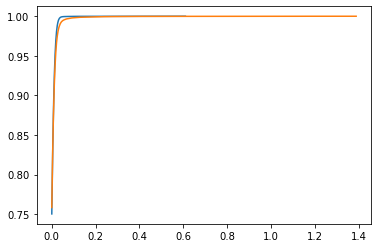

In [89]:
chh=np.cumsum(hh)
plt.plot(ah[:-1],chh/chh[-1])

chp=np.cumsum(hp)
plt.plot(ap[:-1],chp/chp[-1])

In [90]:
ah[np.argmax(0.95<chh/chh[-1])]

0.014890674296117902

Detection image: Fill spot

$fs=\mathcal{R}_{t_m}^{\varepsilon}(f)$

where

$t_m=\begin{cases} f(p) & p \in edges\\ \delta{}_{SE}(f)\end{cases}$

In [91]:
def morph_spot_clean(img,th_peaks=0.95,th_holes=0.95, method=1) :
    if (method == 0) :
        fp=-fill_hole(-img)
        fh=fill_hole(img)
    else : 
        if (method == 1) :
            fp=-fill_spots(-img)
            fh=fill_spots(img)
        else :
            fp=-fill_spots(-img)
            fh=fill_spots(img)
    dh=np.abs(img-fh)
    dp=np.abs(img-fp)
    
    hh,ah=np.histogram(dh.ravel(),bins=1024);
    hp,ap=np.histogram(dp.ravel(),bins=1024);
    chh=np.cumsum(hh)
    chp=np.cumsum(hp)
    thh=ah[np.argmax(0.95<chh/chh[-1])]
    thp=ap[np.argmax(0.95<chp/chp[-1])]
    
    res=img.copy()
    res[thh<dh]=fh[thh<dh]
    res[thp<dp]=fp[thp<dp]
    
    return res

In [92]:
c=morph_spot_clean(timg,th_peaks=0.975,th_holes=0.975)

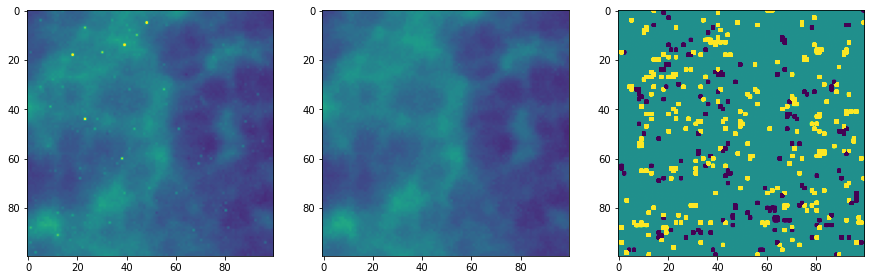

In [93]:
fig,ax =plt.subplots(1,3,figsize=(15,5))
vmin=0.2
vmax=0.8
ax[0].imshow(timg[100:200,400:500],vmin=vmin,vmax=vmax)
ax[1].imshow(c[100:200,400:500],vmin=vmin,vmax=vmax)
d=timg-c
ax[2].imshow(d[100:200,400:500],vmin=-0.0001,vmax=0.0001)


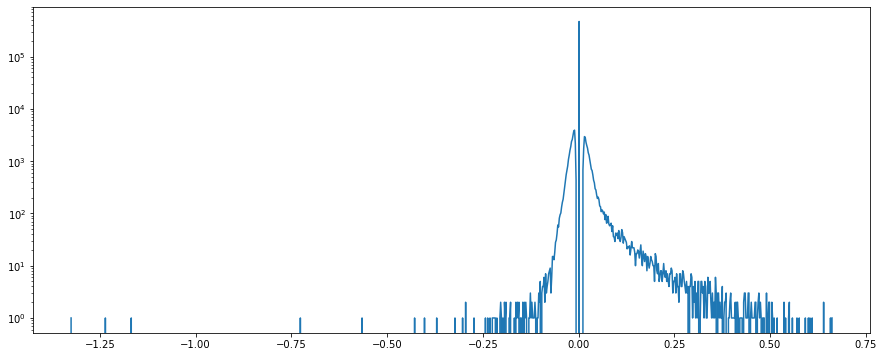

In [94]:
fig,ax=plt.subplots(1,1,figsize=(15,6))
h,a=np.histogram((d/timg).ravel(),bins=1000);
plt.semilogy(a[1:],h)

In [95]:
w=(np.abs(d)<1e-4).sum()/np.prod(d.shape)
w

0.8953514099121094

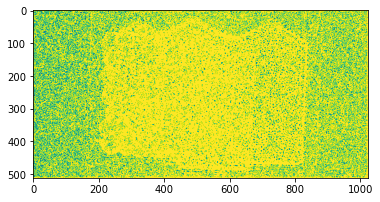

In [96]:
plt.imshow(np.abs(d)<1e-8)

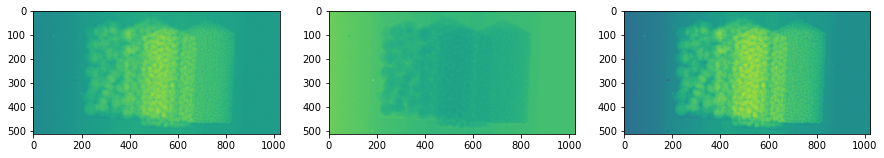

In [97]:
fig,ax =plt.subplots(1,3,figsize=(15,5))
vmin=-2
vmax=2
ax[0].imshow(img,vmin=vmin,vmax=vmax)
ax[1].imshow(c,vmin=vmin,vmax=vmax)
d=img-c
ax[2].imshow(d)